SIAM - Discrete Bath
=======

We calculate the Green function for a SIAM with a discrete bath

$$h = h_0 + h_{\rm int} + h_{\rm bath} + h_{\rm coup}$$

where

$$h_0 = -\mu \, (n_{\uparrow, 0} + n_{\uparrow, 0}) - h(n_{\uparrow,0} - n_{\downarrow,0})$$

$$h_{\rm int} = U n_{\uparrow, 0} n_{\downarrow, 0}$$

$$h_{\rm bath} = \sum_{i=1}^{N} \sum_{\sigma} E_i n_{\sigma,i}$$

and

$$h_{\rm coup} = \sum_{i=1}^{N} \sum_{\sigma} V_i (c^\dagger_{\sigma,i} c_{\sigma,0} + c^\dagger_{\sigma,0} c_{\sigma,i})$$

The parameters are defined below.

In [1]:
# %load model.py
execfile('../common/util.py')

from pytriqs.gf import Gf, MeshImFreq, iOmega_n, inverse
from pytriqs.operators import c, c_dag, n
from itertools import product

# ==== System Parameters ====
beta = 5.           # Inverse temperature
mu = 2.             # Chemical potential
U = 5.              # On-site density-density interaction
h = 0.2             # Local magnetic field
E = [ 0.0, 4.0 ]    # Bath-site energies
V = [ 2.0, 5.0 ]    # Couplings to Bath-sites

# ==== Local Hamiltonian ====
h_0 = - mu*( n('up',0) + n('dn',0) ) - h*( n('up',0) - n('dn',0) )
h_int = U * n('up',0) * n('dn',0)
h_loc = h_0 + h_int

# ==== Bath & Coupling Hamiltonian ====
h_bath, h_coup = 0, 0
for i, E_i, V_i in zip([1, 2], E, V):
    for sig in ['up','dn']:
        h_bath += E_i * n(sig,i)
        h_coup += V_i * (c_dag(sig,0) * c(sig,i) + c_dag(sig,i) * c(sig,0))

# ==== Total impurity hamiltonian and fundamental operators ====
h_imp = h_loc + h_coup + h_bath
fundamental_operators = [ c('up',0), c('dn',0), c('up',1), c('dn',1), c('up',2), c('dn',2) ] # FIXME To be extracted

# ==== Green function structure ====
gf_struct = [ ['up',[0]], ['dn',[0]] ]

# ==== Hybridization Function ====
n_iw = 20
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
Delta = Gf_from_struct(mesh=iw_mesh, struct=gf_struct)
Delta << sum([V_i*V_i * inverse(iOmega_n - E_i) for V_i,E_i in zip(V, E)]);

# ==== Non-Interacting Impurity Green function  ====
G0_iw = Gf_from_struct(mesh=iw_mesh, struct=gf_struct)
G0_iw << inverse(iOmega_n) # FIXME Set tails explicitly

for iw in iw_mesh:
    G0_iw['up'][iw] = 1.0 / (iw + mu + h - Delta['up'][iw])
    G0_iw['dn'][iw] = 1.0 / (iw + mu - h - Delta['dn'][iw])


Results
====

In [2]:
from pytriqs.plot.mpl_interface import oplot, plt
%matplotlib inline

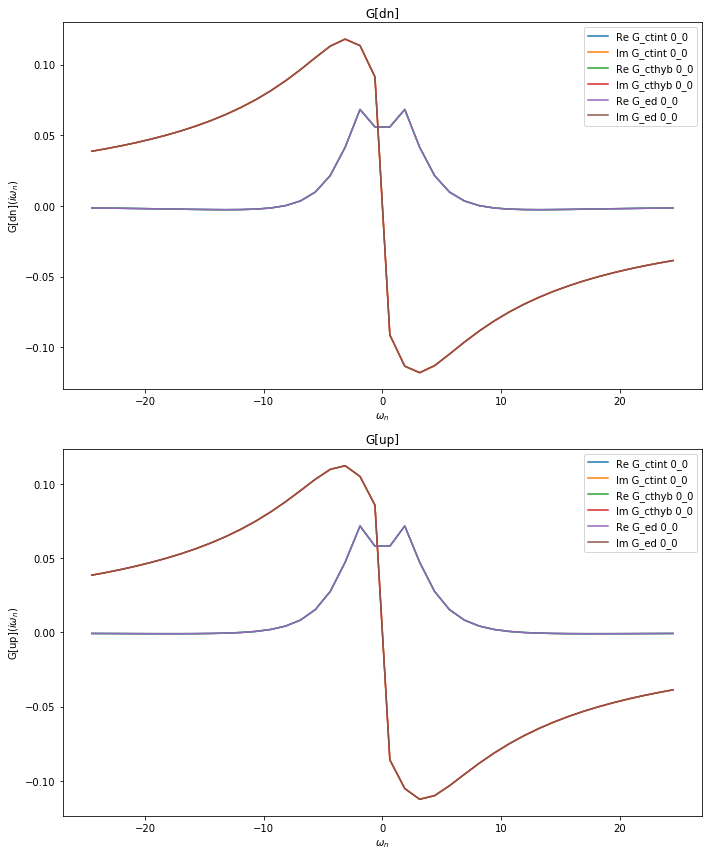

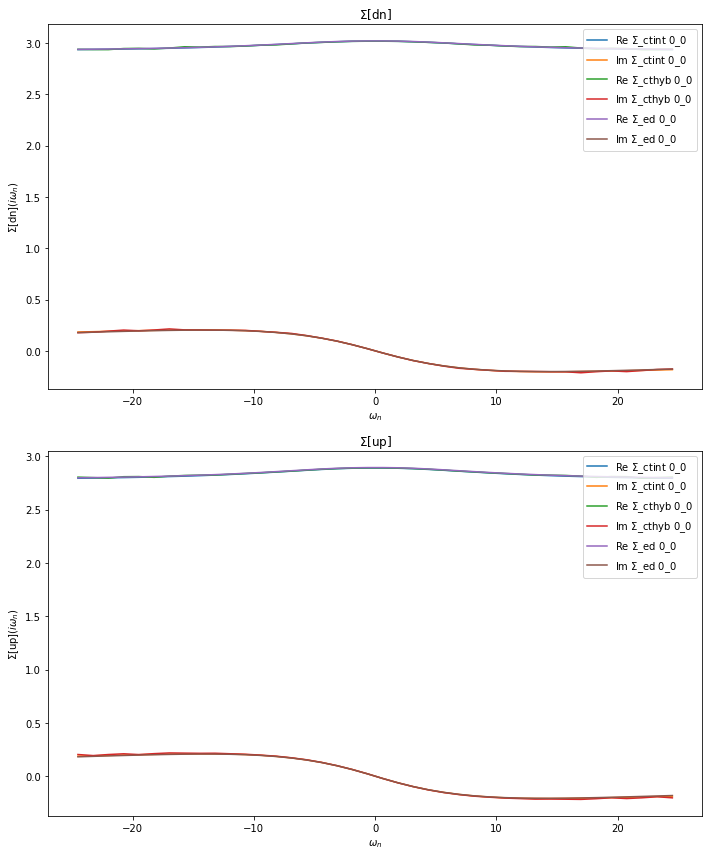

In [3]:
# %load common/plot.py
execfile('model.py')

from pytriqs.archive import HDFArchive
from pytriqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy

solver_lst = [ basename(f).strip('.h5') for f in glob('results/*.h5') ]
G, Sigma = {}, {}

for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    Sigma[solver] = G0_iw.copy()
    Sigma[solver] << inverse(G0_iw) - inverse(G[solver])

# === For every block and solver, plot Green function and Self energy

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

for g, name in [[G, 'G'], [Sigma, '$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for solver in solver_lst:
            oplot(g[solver][block], name = name + "_%s" % solver)
        plt.xlabel("$\omega_n$")
        plt.ylabel(name + "[" + block + "]$(i\omega_n)$")

    plt.tight_layout()
    plt.show()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [4]:
import numpy as np

for block in block_lst:
    deviations = [[ np.amax(np.abs(G[s1][block].data - G[s2][block].data)) for s1 in solver_lst ] \
                    for s2 in solver_lst ]
    
    print "\t\t    Deviations for Block " + block
    print "\t\t -----------------------------------"

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print row_format.format("", *solver_lst)
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print row_format.format(solver, *row)
        
    print "\n\n"

		    Deviations for Block dn
		 -----------------------------------
                         ctint          cthyb             ed
          ctint       0.00E+00       4.06E-05       3.93E-05
          cthyb       4.06E-05       0.00E+00       5.40E-05
             ed       3.93E-05       5.40E-05       0.00E+00



		    Deviations for Block up
		 -----------------------------------
                         ctint          cthyb             ed
          ctint       0.00E+00       3.36E-05       7.27E-05
          cthyb       3.36E-05       0.00E+00       4.86E-05
             ed       7.27E-05       4.86E-05       0.00E+00



